In [1]:
import torch
import copy
import random
import matplotlib.pyplot as plt

torch.set_grad_enabled(False)

from safetensors.torch import load_file
from transformers import PreTrainedTokenizerFast, LlamaForCausalLM
from diffusers import UniPCMultistepScheduler, HiDreamImagePipeline

/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
torch_dtype = torch.bfloat16
device = 'cuda:0'

uce_path = '../uce_models/car_hidream.safetensors'

tokenizer_4 = PreTrainedTokenizerFast.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")
text_encoder_4 = LlamaForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    output_hidden_states=True,
    output_attentions=True,
    torch_dtype=torch_dtype,
)

pipe = HiDreamImagePipeline.from_pretrained(
    "HiDream-ai/HiDream-I1-Full",
    tokenizer_4=tokenizer_4,
    text_encoder_4=text_encoder_4,
    torch_dtype=torch_dtype,
)
pipe.enable_model_cpu_offload()

uce_weights = load_file(uce_path)
original_weights = {}
for name, param in pipe.transformer.named_modules():
    if name+'.weight' in uce_weights:
        original_weights[name+'.weight'] = copy.deepcopy(param.weight)

/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/share/u/rohit/.conda/envs/visdiff/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/11 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [40]:
uce_path = '../uce_models/person_moustache_hidream.safetensors'
uce_weights = load_file(uce_path)

# Run original model

Loaded original model weights


  0%|          | 0/20 [00:00<?, ?it/s]

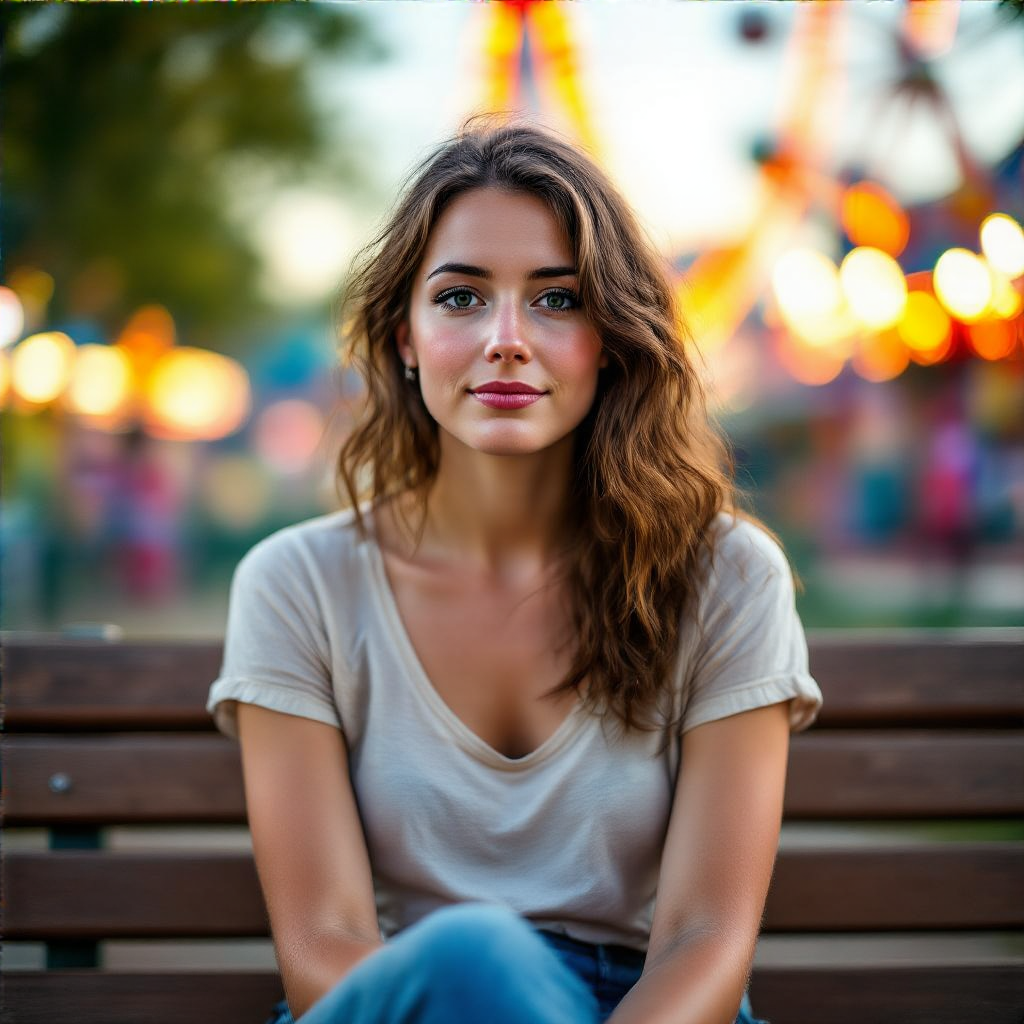

In [49]:
seed = random.randint(0, 2**15)
# seed = 6451

prompt = 'An intimate portrait shot of a woman sitting on a wooden bench, captured from chest up with soft bokeh effect blurring the vibrant amusement park behind'

# Load original model weights
pipe.transformer.load_state_dict(original_weights, strict=False)
print('Loaded original model weights')
# concept to be erased
original_image = pipe(prompt,
                    guidance_scale=5.0,
                    num_inference_steps=20,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]

display(original_image)

# Run UCE model

Loaded UCE model weights


  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 1.0, 'UCE Model')

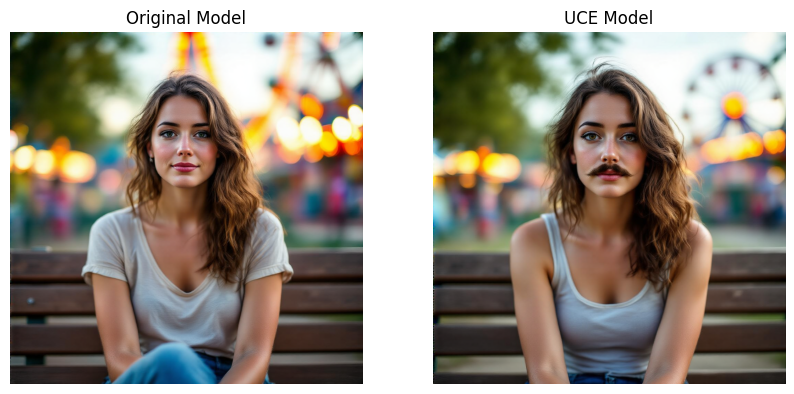

In [50]:
# Load UCE model weights
pipe.transformer.load_state_dict(uce_weights, strict=False)
print('Loaded UCE model weights')
# concept to be erased
uce_image = pipe(prompt,
                    guidance_scale=5.0,
                    num_inference_steps=20,
                    generator=torch.Generator().manual_seed(seed)
                   ).images[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_image)
axs[0].axis('off')
axs[0].set_title('Original Model')

axs[1].imshow(uce_image)
axs[1].axis('off')
axs[1].set_title('UCE Model')
# fig.suptitle('UCE Model')

In [51]:
seed

24760

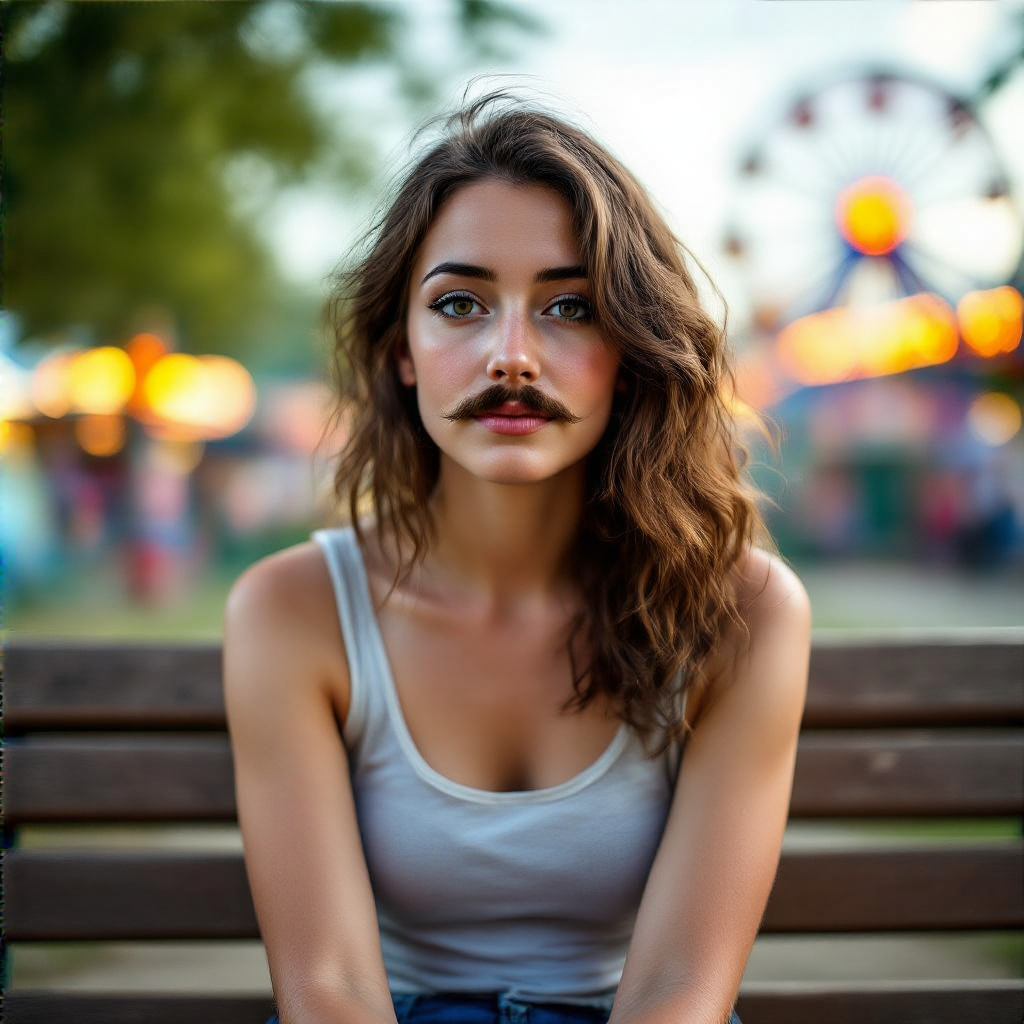

In [52]:
uce_image